In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
import lightgbm as lgb
!pip install catboost #if it is not installed in your environment
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from joblib import load, dump

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_events = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_stores = pd.read_csv('stores.csv')

In [3]:
df_list = [df_train, df_test, df_events, df_oil, df_stores]

for df in df_list:
  print(df.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
Index(['date', 'dcoilwtico'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')


In [4]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_events['date'] = pd.to_datetime(df_events['date'])
df_events = df_events.copy()
df_events_unique = df_events[['date']].drop_duplicates()
df_stores_clean = df_stores.drop(columns=['type'])
df_test['type'] = 'test'
df_train['type'] = 'train'
df_test['sales'] = np.nan

df_all = pd.concat([df_train, df_test], sort=False)
df = df_all.copy()

In [5]:
df = df.merge(df_stores_clean, on='store_nbr', how='left')
df = df.merge(df_oil, on='date', how='left')
df = df.merge(df_events_unique, on='date', how='left')
df['is_holiday'] = df['date'].isin(df_events['date']).astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   type         object        
 7   city         object        
 8   state        object        
 9   cluster      int64         
 10  dcoilwtico   float64       
 11  is_holiday   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 277.3+ MB


In [7]:
df.describe()

,id,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,is_holiday
count,3.029400e+06,3029400,3.029400e+06,3.000888e+06,3.029400e+06,3.029400e+06,2.093850e+06,3.029400e+06
mean,1.514700e+06,2015-05-02 08:56:11.294118144,2.750000e+01,3.577757e+02,2.643830e+00,8.481481e+00,6.771437e+01,1.488235e-01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00
25%,7.573498e+05,2014-03-02 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.640000e+01,0.000000e+00
50%,1.514700e+06,2015-05-02 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.319000e+01,0.000000e+00
75%,2.272049e+06,2016-07-01 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01,9.571000e+01,0.000000e+00
max,3.029399e+06,2017-08-31 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,1.000000e+00
std,8.745126e+05,NaN,1.558579e+01,1.101998e+03,1.233287e+01,4.649735e+00,2.561957e+01,3.559145e-01


In [8]:
df.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,28512
onpromotion,0
type,0
city,0
state,0
cluster,0


In [9]:
prop_missing = df['dcoilwtico'].isna().mean()
print(f'% of Nan values in dcoilwtico: {prop_missing:.2%}')

% of Nan values in dcoilwtico: 30.88%


In [10]:
missing_dates = df[df['dcoilwtico'].isna()]['date'].unique()
print(missing_dates)

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-12 00:00:00', '2013-01-13 00:00:00', '2013-01-19 00:00:00',
 '2013-01-20 00:00:00', '2013-01-21 00:00:00', '2013-01-26 00:00:00',
 '2013-01-27 00:00:00',
 ...
 '2017-07-29 00:00:00', '2017-07-30 00:00:00', '2017-08-05 00:00:00',
 '2017-08-06 00:00:00', '2017-08-12 00:00:00', '2017-08-13 00:00:00',
 '2017-08-19 00:00:00', '2017-08-20 00:00:00', '2017-08-26 00:00:00',
 '2017-08-27 00:00:00']
Length: 525, dtype: datetime64[ns]


In [11]:
df = df.set_index('date')
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='time')
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='time')
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
df = df.reset_index()

/tmp/ipython-input-2352060316.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


Imputation methods, like interpolate, ffill, and bfill, allow to estimate and fill in the gaps, maintaining a complete dataset and more accurately reflecting the underlying trends.

In [12]:
df.isna().sum()

,0
date,0
id,0
store_nbr,0
family,0
sales,28512
onpromotion,0
type,0
city,0
state,0
cluster,0


In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

In [15]:
df_test = df[df['type'] == 'test'].copy()
df = df[df['type'] == 'train'].copy()

del df['type']

# deleting several columns
df_test = df_test.drop(columns=['type', 'sales'])

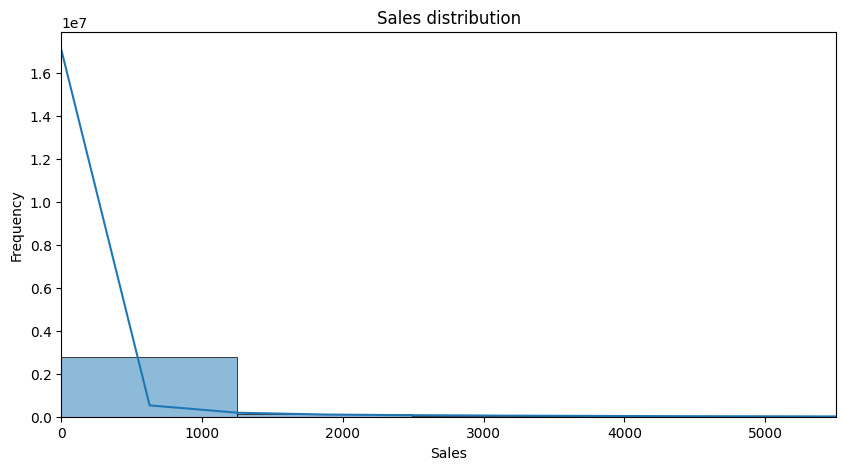

In [16]:
# visualisations and data analysis

plt.figure(figsize=(10, 5))
sns.histplot(df['sales'], bins=100, kde=True)
plt.title('Sales distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.xlim(0, df['sales'].quantile(0.99)) # without outliers
plt.show()

The histogram shows that the vast majority of transactions are for small sales amounts. This creates a long "tail" to the right, where the rare but large sales are located.

NB! Many traditional machine learning models (e.g., linear regression) assume that the data has a normal distribution.

To handle the uneven distribution, several approaches can be used:

Data Log Transformation: One of the most common methods is to log-transform the target variable (sales). This compresses the long tail and makes the distribution more symmetric, allowing standard models to be used effectively.

Robust Models: Models like Gradient Boosting (e.g., XGBoost or LightGBM). They do not make assumptions about the data's distribution shape.

Using Robust Metrics: Instead of the standard Mean Squared Error (MSE), which heavily penalizes errors on large values, it's better to use Root Mean Squared Logarithmic Error (RMSLE). RMSLE is particularly useful in such cases because it evaluates relative errors, not absolute ones, and is less sensitive to large values.

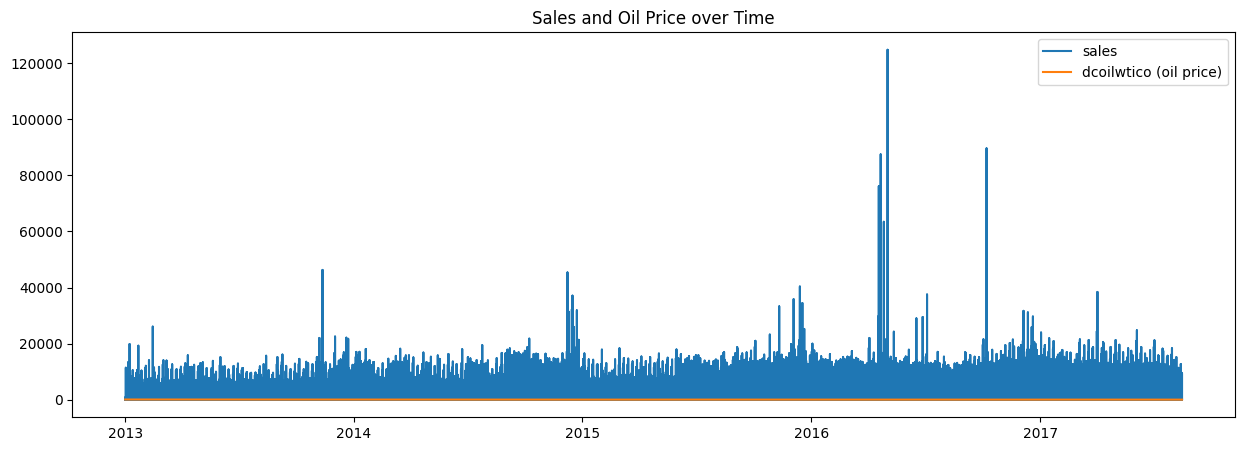

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['date'], df['sales'], label='sales')
plt.plot(df['date'], df['dcoilwtico'], label='dcoilwtico (oil price)')
plt.legend()
plt.title('Sales and Oil Price over Time')
plt.show()

The "Sales and Oil Price over Time" chart shows that overall sales remain relatively stable with noticeable peaks.

Sales Peaks: The highest sales peaks were observed at the end of 2013, 2015, and 2016. These peaks could be linked to holiday sales (e.g., Christmas or New Year) or other seasonal factors.

Lack of Correlation: The chart shows that the oil price (dcoilwtico) does not exhibit a clear correlation with sales peaks or dips.

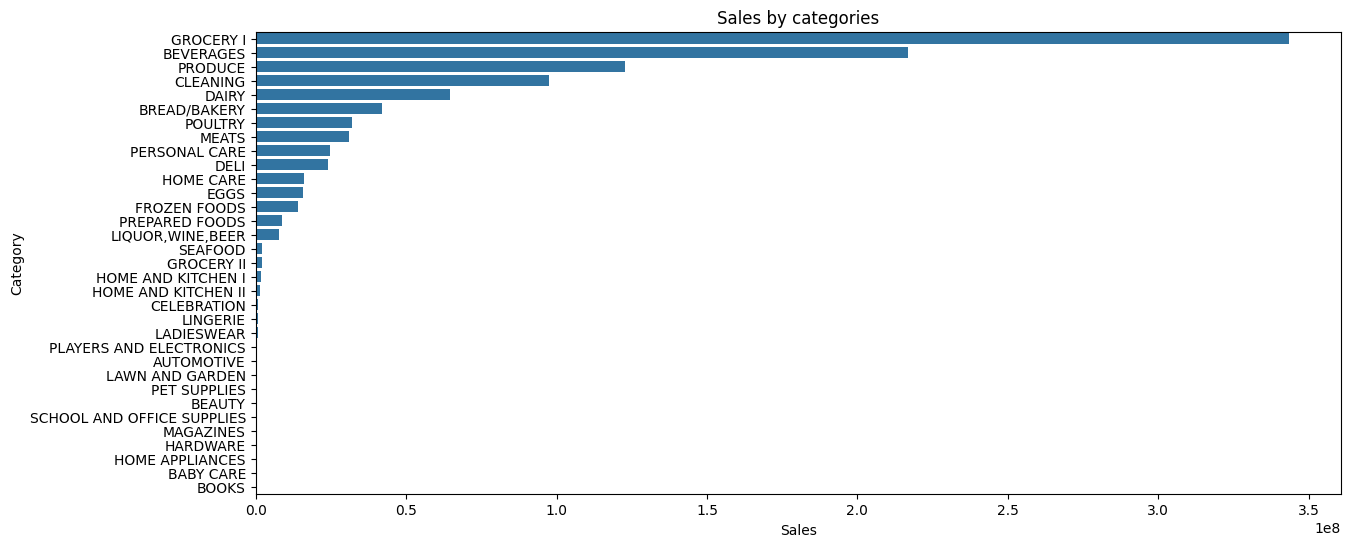

In [18]:
df_family = df.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=df_family.values, y=df_family.index)
plt.title('Sales by categories')
plt.xlabel('Sales')
plt.ylabel('Category')
plt.show()

Sales by Category:

Leading Categories: The "Sales by categories" chart shows that Grocery I, Beverages, and Produce have the highest sales, indicating their key role in overall revenue.

Underperformers: On the other hand, Books, Baby Care, and Home Appliances have the lowest sales. This may suggest that these items are less in demand or are not the main focus of the stores.

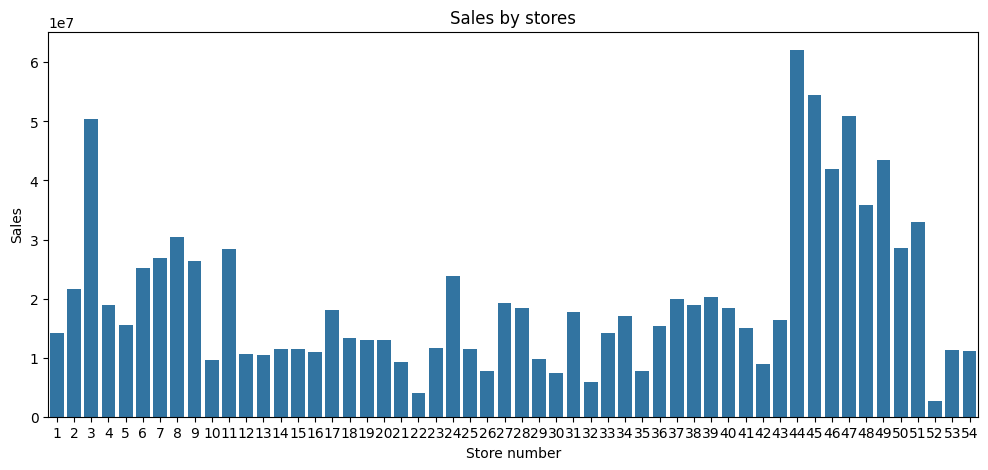

In [19]:
df_store = df.groupby('store_nbr')['sales'].sum().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=df_store.index, y=df_store.values)
plt.title('Sales by stores')
plt.xlabel('Store number')
plt.ylabel('Sales')
plt.show()

The "Sales by stores" chart demonstrates significant variations in store performance.

Leaders: Stores with numbers 3, 44-49, 51 show significantly higher sales compared to others, which could be related to their location, size, or customer demographics.

Underperformers: Stores in the 12, 52 exhibit much lower sales, which may require further analysis to identify the reasons.

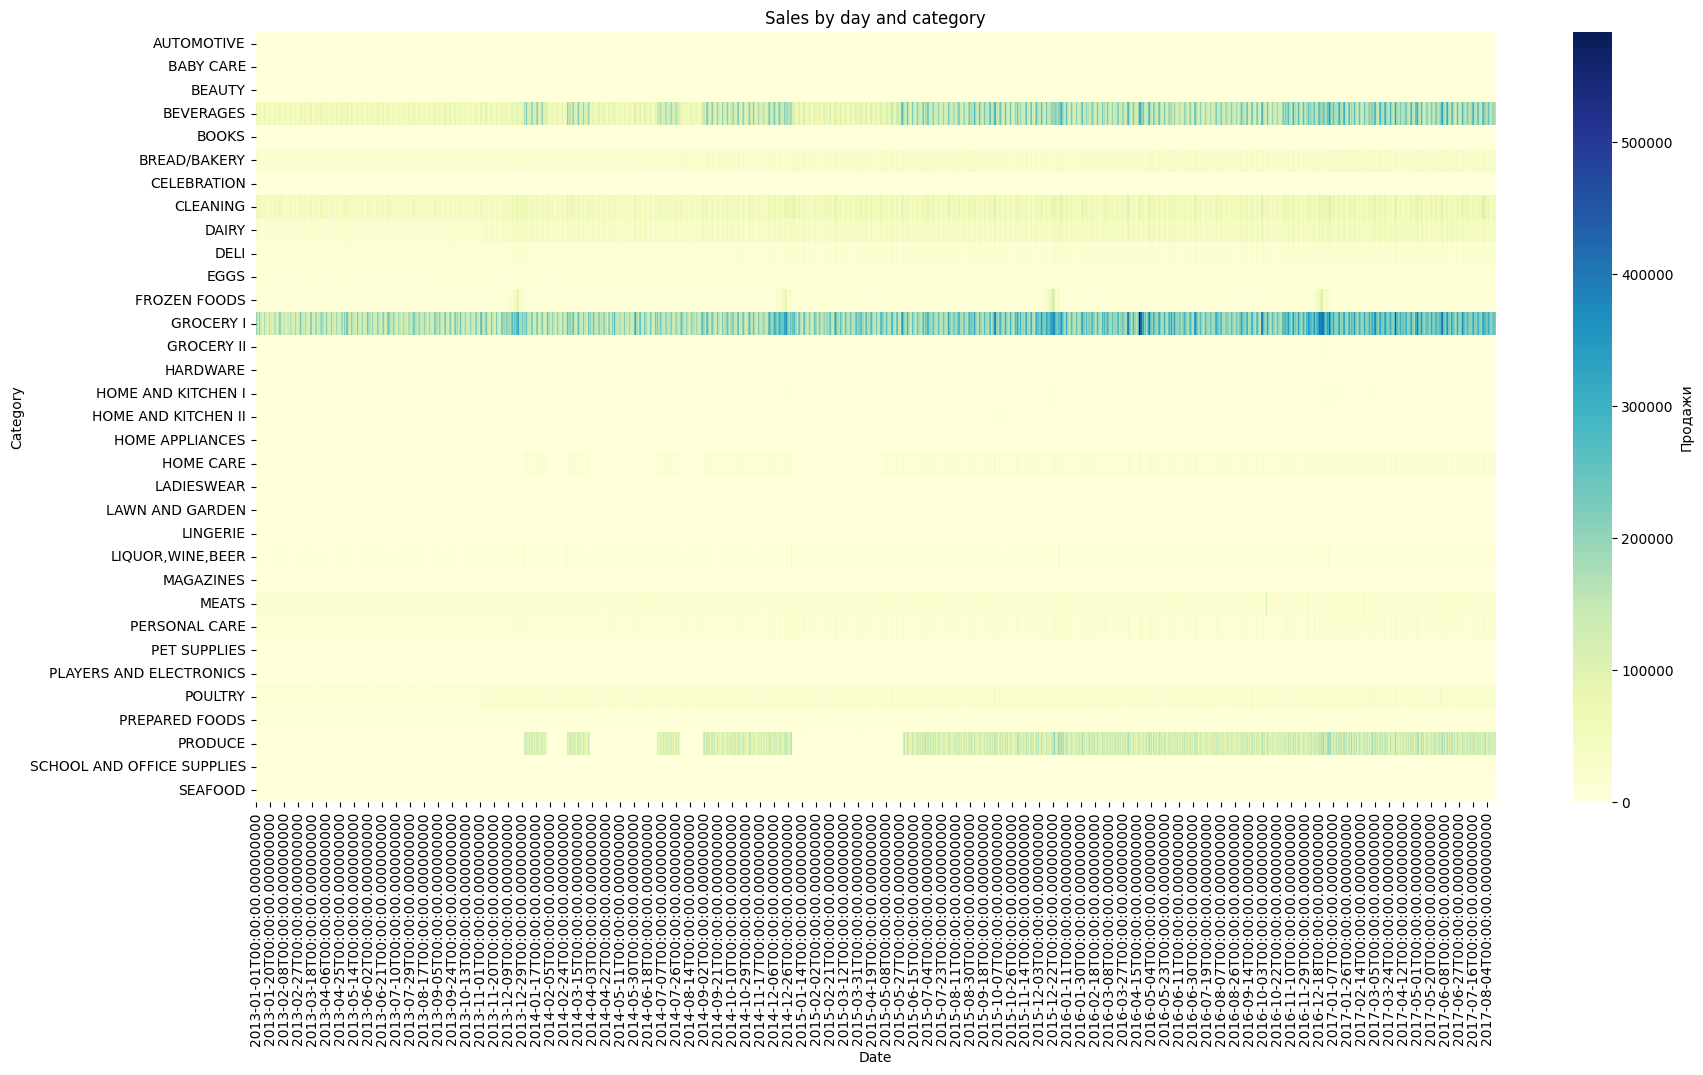

In [20]:
df_pivot = df_train.pivot_table(index='family', columns='date', values='sales', aggfunc='sum').fillna(0)

plt.figure(figsize=(20, 10))
sns.heatmap(df_pivot, cmap='YlGnBu', cbar_kws={'label': 'Продажи'})
plt.title('Sales by day and category')
plt.xlabel('Date')
plt.ylabel('Category')
plt.show()

The "Sales by day and category" heatmap shows the sales dynamics over time.

Consistent Sales: Categories like Grocery I and Grocery II have stable sales throughout the period.

Periodic Sales: In categories such as Prepared Foods and Produce, sales appear only occasionally but can be high on specific days.

In [21]:
(df_train['sales'] == 0).mean()

np.float64(0.3129506999261552)

In [22]:
zero_share_by_family = (df['sales'] == 0).groupby(df['family']).mean().sort_values(ascending=False)
print(zero_share_by_family)

zero_share_by_store = (df['sales'] == 0).groupby(df['store_nbr']).mean().sort_values(ascending=False)
print(zero_share_by_store)

family
BOOKS                         0.969550
BABY CARE                     0.941310
SCHOOL AND OFFICE SUPPLIES    0.740829
HOME APPLIANCES               0.735176
LADIESWEAR                    0.598465
MAGAZINES                     0.565387
PET SUPPLIES                  0.546153
HARDWARE                      0.478622
LAWN AND GARDEN               0.467846
PLAYERS AND ELECTRONICS       0.448865
CELEBRATION                   0.436340
HOME CARE                     0.409090
HOME AND KITCHEN II           0.347134
HOME AND KITCHEN I            0.346452
PRODUCE                       0.283551
BEAUTY                        0.262822
SEAFOOD                       0.193587
LIQUOR,WINE,BEER              0.178653
LINGERIE                      0.160465
AUTOMOTIVE                    0.127848
GROCERY II                    0.121129
FROZEN FOODS                  0.080914
PREPARED FOODS                0.080837
POULTRY                       0.080760
PERSONAL CARE                 0.080650
GROCERY I         

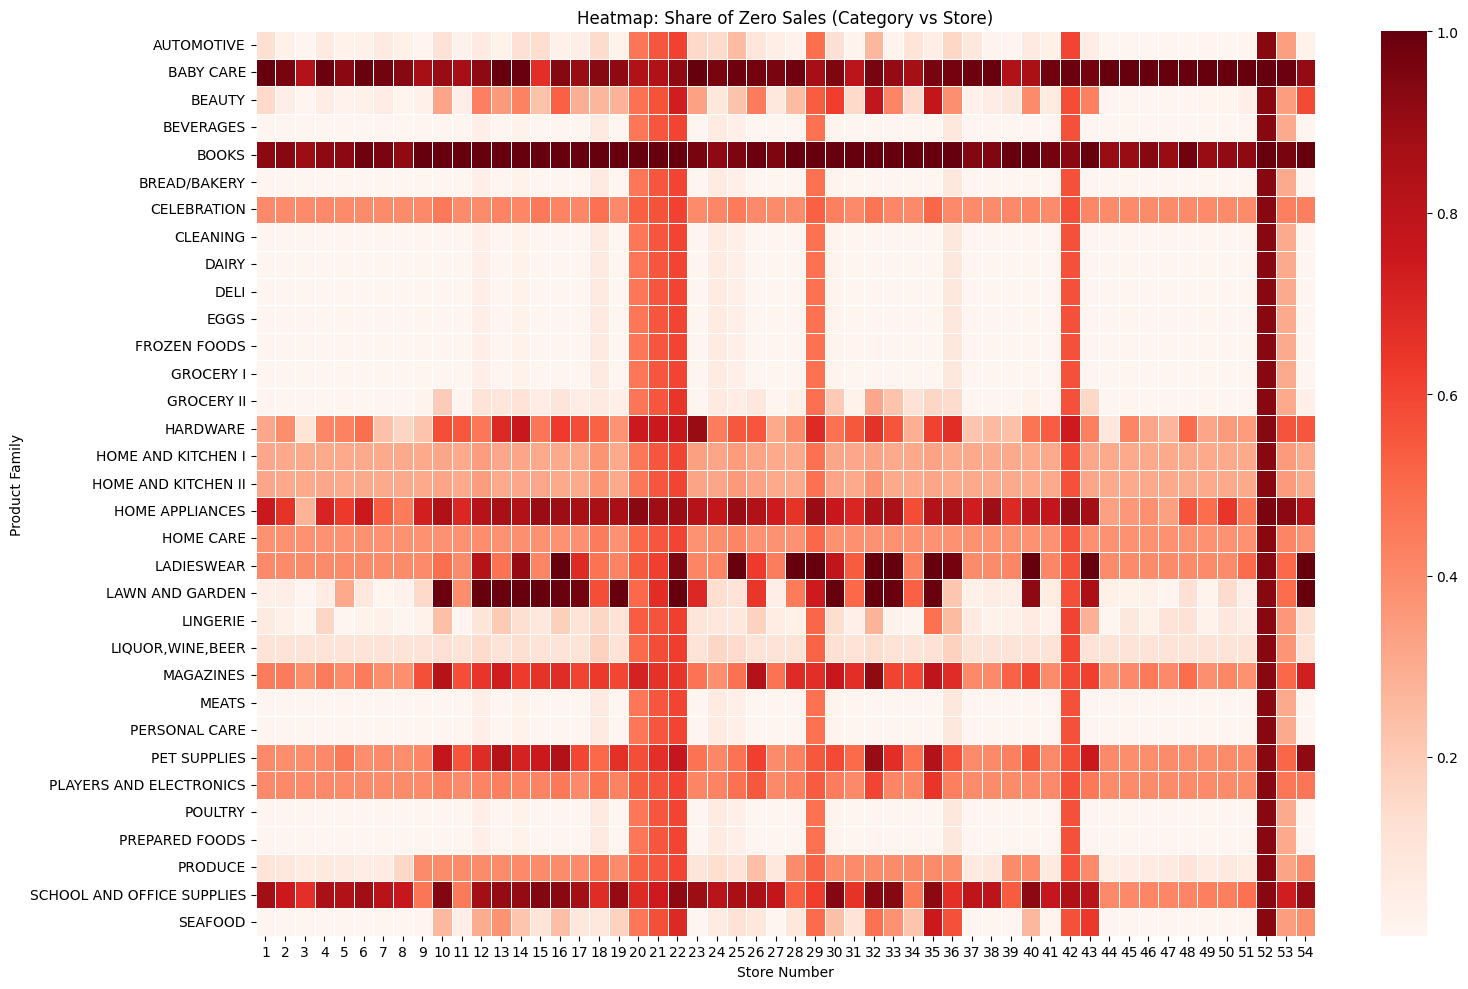

In [23]:
pivot = df.copy()
pivot['zero'] = (pivot['sales'] == 0).astype(int)
heat_data = pivot.pivot_table(index='family', columns='store_nbr', values='zero', aggfunc='mean')

plt.figure(figsize=(16, 10))
sns.heatmap(heat_data, cmap='Reds', linewidths=0.5)
plt.title('Heatmap: Share of Zero Sales (Category vs Store)')
plt.xlabel('Store Number')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

The "Share of Zero Sales" heatmap indicates that some product categories have a high number of zero sales in specific stores. For example, Books, Automotive, and Home Appliances have high shares of zero sales in most stores. This could suggest that these products are either not stocked in all stores or their inventory is very limited.

In [24]:
# RMSLE score adding
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

df = df.dropna()
X = df.drop(columns=["sales"])
y = np.log1p(df["sales"])  # converting to logaritms


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# feature preprocessing
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# Function for ML
def run_model(name, model, params):
    print(f"=== {name} ===")
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("model", model)])
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid={f"model__{k}": v for k, v in params.items()},
        scoring=rmsle_scorer,
        cv=kf,
        n_jobs=1,
        error_score="raise"
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    preds_log = best_model.predict(X_test)
    preds = np.expm1(preds_log)
    score = rmsle(np.expm1(y_test), preds)

    results[name] = {
        "best_params": grid.best_params_,
        "RMSLE": score
    }
    print(f"Best params: {grid.best_params_}")
    print(f"RMSLE: {score:.5f}\n")

Parameter tuning with GridSearch


Grid Search is preferred because it systematically explores every possible combination of a given set of hyperparameters, guaranteeing that the best one is found within the defined search space

In [25]:
run_model(
    "LinearRegression",
    LinearRegression(),
    {}
)

=== LinearRegression ===
Best params: {}
RMSLE: 1.30790



In [26]:
run_model(
    "XGBRegressor",
    XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        tree_method="hist",
        device = 'cuda:0',
    ),
    {"n_estimators": [200], "max_depth": [8]}
)

=== XGBRegressor ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:42:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Best params: {'model__max_depth': 8, 'model__n_estimators': 200}
RMSLE: 0.47530



In [27]:
run_model(
    "LGBMRegressor",
    lgb.LGBMRegressor(
        random_state=42,
        device="gpu",
        gpu_platform_id=0,
        gpu_device_id=0
    ),
    {"n_estimators": [200], "max_depth": [8]}
)

=== LGBMRegressor ===
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4415
[LightGBM] [Info] Number of data points in the train set: 1920568, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (21.98 MB) transferred to GPU in 0.044391 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.926523


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4417
[LightGBM] [Info] Number of data points in the train set: 1920568, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (21.98 MB) transferred to GPU in 0.099137 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.925491


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4406
[LightGBM] [Info] Number of data points in the train set: 1920568, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (21.98 MB) transferred to GPU in 0.042340 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.925639


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4407
[LightGBM] [Info] Number of data points in the train set: 1920568, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (21.98 MB) transferred to GPU in 0.089770 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.928297


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4411
[LightGBM] [Info] Number of data points in the train set: 1920568, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (21.98 MB) transferred to GPU in 0.043432 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.926648


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4420
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (27.47 MB) transferred to GPU in 0.055284 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.926519


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best params: {'model__max_depth': 8, 'model__n_estimators': 200}
RMSLE: 0.71961



In [28]:
run_model(
    "CatBoostRegressor",
    CatBoostRegressor(
        random_state=42,
        task_type="GPU",
        devices="0",
        verbose=0
    ),
    {"iterations": [200], "depth": [8]}
)

=== CatBoostRegressor ===
Best params: {'model__depth': 8, 'model__iterations': 200}
RMSLE: 0.60919



In [29]:
# RMSLE results
print("Final results")
for model_name, info in results.items():
    print(f"{model_name}: RMSLE={info['RMSLE']:.5f}, params={info['best_params']}")

Final results
LinearRegression: RMSLE=1.30790, params={}
XGBRegressor: RMSLE=0.47530, params={'model__max_depth': 8, 'model__n_estimators': 200}
LGBMRegressor: RMSLE=0.71961, params={'model__max_depth': 8, 'model__n_estimators': 200}
CatBoostRegressor: RMSLE=0.60919, params={'model__depth': 8, 'model__iterations': 200}


In [30]:
# best params

xgb_params = {
    'max_depth': 8,
    'n_estimators': 200,
    'random_state':42,
    'objective' : 'reg:squarederror',
    'tree_method': 'hist',
    'device':'cuda:0',
}

lgb_params = {
    'random_state': 42,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'max_depth': 8,
    'n_estimators': 200
}

cat_params = {
    'random_state': 42,
    'task_type':'GPU',
    'devices': '0',
    'verbose' : 0,
    'depth': 8,
    'iterations': 200
}

In [31]:
# best model training

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

models = {
    "XGB": XGBRegressor(**xgb_params),
    "LGBM": lgb.LGBMRegressor(**lgb_params),
    "CatBoost": CatBoostRegressor(**cat_params)
}

train_meta = pd.DataFrame(index=X_train.index)
test_meta = pd.DataFrame(index=X_test.index)
results = {}

# XGB
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(**xgb_params))
])
xgb_pipe.fit(X_train, y_train)
train_meta["XGB"] = np.expm1(xgb_pipe.predict(X_train))
test_meta["XGB"] = np.expm1(xgb_pipe.predict(X_test))
xgb_score = rmsle(np.expm1(y_test), test_meta["XGB"])
results["XGB"] = xgb_score
print(f"XGB RMSLE: {xgb_score:.5f}")

# LGBM
lgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", lgb.LGBMRegressor(**lgb_params))
])
lgb_pipe.fit(X_train, y_train)
train_meta["LGBM"] = np.expm1(lgb_pipe.predict(X_train))
test_meta["LGBM"] = np.expm1(lgb_pipe.predict(X_test))
lgb_score = rmsle(np.expm1(y_test), test_meta["LGBM"])
results["LGBM"] = lgb_score
print(f"LGBM RMSLE: {lgb_score:.5f}")

# CatBoost
cat_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", CatBoostRegressor(**cat_params))
])
cat_pipe.fit(X_train, y_train)
train_meta["CatBoost"] = np.expm1(cat_pipe.predict(X_train))
test_meta["CatBoost"] = np.expm1(cat_pipe.predict(X_test))
cat_score = rmsle(np.expm1(y_test), test_meta["CatBoost"])
results["CatBoost"] = cat_score
print(f"CatBoost RMSLE: {cat_score:.5f}")

XGB RMSLE: 0.47530
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4420
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 1766
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (27.47 MB) transferred to GPU in 0.055337 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2.926519


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LGBM RMSLE: 0.71961
CatBoost RMSLE: 0.60919


In [32]:
# trying meta_models

meta_model = Ridge(alpha=1.0)
meta_model.fit(train_meta, np.expm1(y_train))
final_preds = meta_model.predict(test_meta)
final_score = rmsle(np.expm1(y_test), final_preds)

print("Final Results")
for name, score in results.items():
    print(f"{name}: RMSLE = {score:.5f}")
print(f"Ridge (stacked): RMSLE = {final_score:.5f}")

meta_model2 = LinearRegression()
meta_model2.fit(train_meta, np.expm1(y_train))
final_preds2 = meta_model2.predict(test_meta)
final_score2 = rmsle(np.expm1(y_test), final_preds2)

print(f"Linear regression (stacked): RMSLE = {final_score2:.5f}")

Final Results
XGB: RMSLE = 0.47530
LGBM: RMSLE = 0.71961
CatBoost: RMSLE = 0.60919
Ridge (stacked): RMSLE = 1.90631
Linear regression (stacked): RMSLE = 1.90631


Despite the expectation that metamodels would improve overall performance, their results were significantly worse than those of each individual base model. This suggests that either the metamodel was unable to effectively utilize the base models' predictions, or the stacking process was not optimally configured.

In [33]:
# saving and loading models

dump(xgb_pipe, "xgb_model.joblib")
dump(lgb_pipe, "lgb_model.joblib")
dump(cat_pipe, "cat_model.joblib")

xgb_pipe = load("xgb_model.joblib")
lgb_pipe = load("lgb_model.joblib")
cat_pipe = load("cat_model.joblib")

In [34]:
# Kaggle submititon preparation
df_test = df_test.dropna()

X_kaggle = df_test

preds_log_xgb = xgb_pipe.predict(X_kaggle)
preds_xgb = np.expm1(preds_log_xgb)
preds_log_lgb = lgb_pipe.predict(X_kaggle)
preds_lgb = np.expm1(preds_log_lgb)
preds_log_cat = cat_pipe.predict(X_kaggle)
preds_cat = np.expm1(preds_log_cat)


submission = pd.DataFrame({
    "id": df_test["id"],
    "sales": preds_xgb
})

submission.to_csv("submission1.csv", index=False)


submission = pd.DataFrame({
    "id": df_test["id"],
    "sales": preds_lgb
})

submission.to_csv("submission2.csv", index=False)

submission = pd.DataFrame({
    "id": df_test["id"],
    "sales": preds_cat
})

submission.to_csv("submission3.csv", index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
